Домашнее задание
Скачать из датасета Kinetics 700-2020 видео с классами содержащими слово dancing

Нельзя использовать веса предобученные на Kinetics!

Обучить модель на отдельных кадрах - 3 балла
Обучить модель классификации этих видео на основе Pose Estimation - 4 балла - взять модель для pose estimation, вытаскивать координаты точек
Построить с нуля и обучить модель классификации видео на основе 3D свёрток или трансформеров - 5 баллов - 3д свертки из пайторча, построить реснет с нуля

In [20]:
!pip install datasets huggingface-hub transformers fiftyone decord av pytube -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import random
import tarfile

import cv2
import numpy as np
import torch
from fiftyone.utils.kinetics import Kinetics7002020DatasetInfo
from fiftyone.utils.kinetics import KineticsDatasetDownloader
# from google.colab import drive
from sklearn.metrics import f1_score, accuracy_score
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import models, transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare dataset

## Get dancing classes

In [26]:
kinetics_dir = "."
scratch_dir = "."
split = "train"

dataset_info = Kinetics7002020DatasetInfo(kinetics_dir, scratch_dir, split)

 100% |████|  189.7Mb/189.7Mb [1.6s elapsed, 0s remaining, 194.0Mb/s]      
 100% |████|  388.3Kb/388.3Kb [132.4ms elapsed, 0s remaining, 2.9Mb/s] 


In [27]:
dancing_classes = [cls for cls in dataset_info.all_classes if "dancing" in cls]
dancing_classes

['belly dancing',
 'breakdancing',
 'country line dancing',
 'dancing ballet',
 'dancing charleston',
 'dancing gangnam style',
 'dancing macarena',
 'jumpstyle dancing',
 'mosh pit dancing',
 'robot dancing',
 'salsa dancing',
 'square dancing',
 'swing dancing',
 'tango dancing',
 'tap dancing']

## Download videos

In [28]:
downloader = KineticsDatasetDownloader(num_workers=None)
dataset_dir = "."
split = "train"

did_download = False
for cls in dancing_classes[:5]:
    try:
        downloader.download_classes(dataset_info, [cls])
        did_download = True
    except KeyError:
        print(f"Skipping class '{cls}' as it is not found in the dataset")

 100% |██████|    5.6Gb/5.6Gb [2.7m elapsed, 0s remaining, 23.2Mb/s]      
 100% |██████|    7.0Gb/7.0Gb [2.7m elapsed, 0s remaining, 42.7Mb/s]       
 100% |██████|    7.5Gb/7.5Gb [3.1m elapsed, 0s remaining, 54.9Mb/s]      
 100% |██████|    6.6Gb/6.6Gb [3.2m elapsed, 0s remaining, 51.4Mb/s]       
 100% |██████|    8.2Gb/8.2Gb [3.3m elapsed, 0s remaining, 45.8Mb/s]       


## Unarchive and remove .tars

In [29]:
os.chdir("./")

for filename in os.listdir():
    if filename.startswith("k700") and filename.endswith(".tar.gz"):
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall("./kinetics")

        os.remove(filename)

In [35]:
# os.chdir("./")
# files = os.listdir()
# tar_gz_files = [f for f in files if f.endswith(".tar.gz")]
# 
# for f in tar_gz_files:
#     os.remove(f)

# Train model

## Util functions

In [30]:
np.random.seed(0)


def read_video_pyav(container, indices):
    """
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    """
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [45]:
!rm -r ./kinetics_frames

In [31]:
def sample_frame_indices(total_frames, num_frames):
    return random.sample(range(total_frames), min(num_frames, total_frames))


def read_video_opencv(video_path, indices):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    return frames


subfolders = [f.path for f in os.scandir("./kinetics") if f.is_dir()]

for subfolder in subfolders:
    video_files = [f for f in os.listdir(subfolder)[:20] if f.endswith(".mp4")]

    frames_subfolder = subfolder.replace("./kinetics", "./kinetics_frames")
    os.makedirs(frames_subfolder, exist_ok=True)

    for video_file in video_files:
        video_path = os.path.join(subfolder, video_file)

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = sample_frame_indices(total_frames, 30)

        frames = read_video_opencv(video_path, indices)
        for i, frame in enumerate(frames):
            np.save(os.path.join(frames_subfolder, f"{video_file.replace('.mp4', '')}_{i}.npy"), frame)

        cap.release()

## Dataset class

In [127]:
from pathlib import Path

folders = list(Path(dataset_dir).iterdir())

val_names, train_names = [], []
for folder in folders:
    files = list(folder.glob("*.npy"))
    names = list(set([file.name.split('_')[0] for file in files]))

    val_names.extend(names[:len(names) // 5])
    train_names.extend(names[len(names) // 5:])

In [41]:
dataset_dir = "./kinetics_frames"


class KineticsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None, subset: list[str] = None):
        self.dataset_dir = dataset_dir
        self.classes = sorted(os.listdir(dataset_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            class_dir = os.path.join(dataset_dir, cls)
            for frame_file in os.listdir(class_dir):
                if subset is None or str(frame_file).split("_")[0] in subset:
                    self.samples.append((os.path.join(class_dir, frame_file), self.class_to_idx[cls]))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_path, label = self.samples[idx]
        frame = np.load(frame_path)
        if self.transform:
            frame = self.transform(frame)
        return frame, label

In [99]:
dataset_dir = "./kinetics_frames"


class KineticsValidationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None, subset: list[str] = None):
        self.dataset_dir = dataset_dir
        self.classes = sorted(os.listdir(dataset_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            class_dir = os.path.join(dataset_dir, cls)
            for frame_file in os.listdir(class_dir):
                name = str(frame_file).split("_")[0]
                if subset is None or name in subset:
                    self.samples.append((os.path.join(class_dir, frame_file), (self.class_to_idx[cls], name)))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_path, label = self.samples[idx]
        frame = np.load(frame_path)
        if self.transform:
            frame = self.transform(frame)
        return frame, label

## Init

In [72]:
# drive.mount("/content/drive")
# 
# !cp -r ./kinetics_frames /content/drive/MyDrive/kinetics_frames

Mounted at /content/drive


In [1]:
# drive.mount("/content/drive")
# 
# !cp -r /content/drive/MyDrive/kinetics_frames ./

Mounted at /content/drive


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [

        transforms.ToPILImage(),
        # transforms.Grayscale(num_output_channels=3),  # Convert image to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

batch_size = 32
dataset = KineticsDataset(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [62]:
td = KineticsDataset(dataset_dir, transform=transform, subset=val_names)
td[0]

(tensor([[[0.3686, 0.4196, 0.4510,  ..., 0.1059, 0.1098, 0.0980],
          [0.2118, 0.3216, 0.4314,  ..., 0.1176, 0.1216, 0.1098],
          [0.1647, 0.2157, 0.3961,  ..., 0.1255, 0.1255, 0.1216],
          ...,
          [0.2235, 0.2314, 0.2275,  ..., 0.2392, 0.2353, 0.2353],
          [0.2510, 0.2667, 0.2706,  ..., 0.2549, 0.2471, 0.2471],
          [0.2235, 0.2431, 0.2392,  ..., 0.2627, 0.2588, 0.2667]],
 
         [[0.4196, 0.5020, 0.5686,  ..., 0.1961, 0.2118, 0.1882],
          [0.2667, 0.3922, 0.5373,  ..., 0.2078, 0.2235, 0.2000],
          [0.2118, 0.2627, 0.4627,  ..., 0.2235, 0.2392, 0.2196],
          ...,
          [0.3490, 0.3451, 0.3412,  ..., 0.4941, 0.4902, 0.4902],
          [0.4588, 0.4745, 0.4784,  ..., 0.5098, 0.5020, 0.5020],
          [0.4510, 0.4706, 0.4784,  ..., 0.5137, 0.5137, 0.5216]],
 
         [[0.5294, 0.5882, 0.6431,  ..., 0.3059, 0.3176, 0.3137],
          [0.3765, 0.4824, 0.6118,  ..., 0.3176, 0.3294, 0.3255],
          [0.3255, 0.3569, 0.5451,  ...,

## Training loop

# new

In [69]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset = KineticsDataset(dataset_dir, transform=transform, subset=train_names)
# val_dataset = KineticsDataset(dataset_dir, transform=transform, subset=val_names)
# train_dataset, val_dataset = random_split(dataset, [train_size, test_size])
# indices = torch.randperm(len(train_dataset)).tolist()
# sampler = SubsetRandomSampler(indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #, sampler=sampler)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

val_dataset = KineticsValidationDataset(dataset_dir, transform=transform, subset=val_names)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

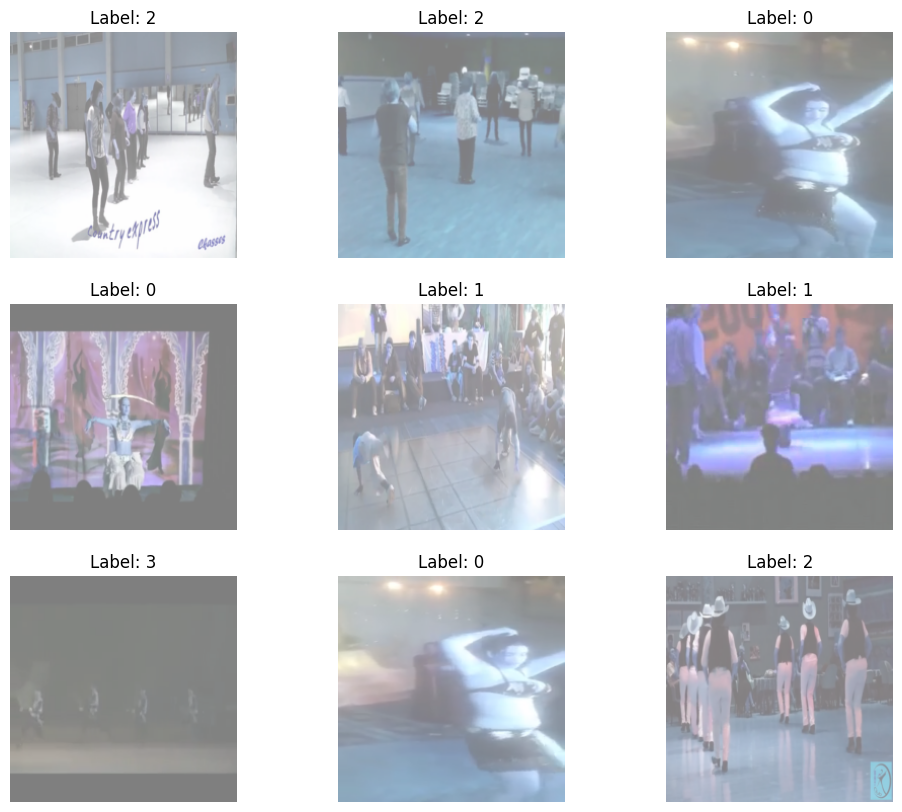

In [58]:
import torch
import matplotlib.pyplot as plt
import torchvision


def show_images(loader):
    for images, labels in loader:
        _ = plt.figure(figsize=(12, 10))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.title("Label: " + str(labels[i].item()))
            plt.axis('off')
            img = images[i] / 2 + 0.5
            img = torchvision.transforms.ToPILImage()(img)
            plt.imshow(img)
        break
    plt.show()


loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
show_images(loader)

In [126]:
from collections import defaultdict, Counter


def sort_names(dct):
    return dict(sorted(dct.items(), key=lambda x: x[0].lower()))


def aggregate_video_predictions(val_labels_batch, val_names_batch, val_preds_batch, res_ground_truth, res_prediction):
    for batch_idx, pred in enumerate(val_preds_batch):
        gd, video_name = val_labels_batch, val_names_batch
        res_ground_truth[video_name[batch_idx]].append(gd[batch_idx].item())
        res_prediction[video_name[batch_idx]].append(pred.item())

    return res_ground_truth, res_prediction


def evaluate_model(model, val_dataloader):
    with torch.no_grad():
        res_ground_truth = defaultdict(list)
        res_prediction = defaultdict(list)

        for val_inputs, (val_labels_batch, val_names_batch) in val_dataloader:
            val_inputs, val_labels_batch = val_inputs.to(device), val_labels_batch.to(device)

            val_outputs = model(val_inputs)
            _, val_preds_batch = torch.max(val_outputs, 1)

            res_ground_truth, res_prediction = aggregate_video_predictions(
                val_labels_batch, val_names_batch,
                val_preds_batch, res_ground_truth,
                res_prediction, 
            )

        processed_gd = sort_names({key: Counter(lst).most_common(1)[0][0] for key, lst in res_ground_truth.items()})
        processed_pred = sort_names({key: Counter(lst).most_common(1)[0][0] for key, lst in res_prediction.items()})
        assert processed_gd.keys() == processed_pred.keys()

        val_f1 = f1_score(list(processed_gd.values()), list(processed_pred.values()), average="weighted")
        val_accuracy = accuracy_score(list(processed_gd.values()), list(processed_pred.values()))
        return val_f1, val_accuracy


num_classes = 5
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model.to(device)

num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 3 == 0:
        model.eval()
        val_labels = []
        val_preds = []

        val_f1, val_accuracy = evaluate_model(model, val_dataloader)
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Finished Training")

Epoch 1/12, Loss: 2.5883
Epoch 2/12, Loss: 1.7802
Epoch 3, Validation Accuracy: 0.3164, Validation F1 Score: 0.1841
Epoch 3/12, Loss: 1.4780
Epoch 4/12, Loss: 1.3187
Epoch 5/12, Loss: 1.0526
Epoch 6, Validation Accuracy: 0.3913, Validation F1 Score: 0.2975
Epoch 6/12, Loss: 0.8769
Epoch 7/12, Loss: 0.7344
Epoch 8/12, Loss: 0.5988
Epoch 9, Validation Accuracy: 0.4774, Validation F1 Score: 0.3951
Epoch 9/12, Loss: 0.4054
Epoch 10/12, Loss: 0.2614
Epoch 11/12, Loss: 0.2115
Epoch 12, Validation Accuracy: 0.4946, Validation F1 Score: 0.4124
Epoch 12/12, Loss: 0.1672
Finished Training
